<a href="https://colab.research.google.com/github/DAbbott93/Dean-Abbott--Dissertation/blob/main/Model_5_DistilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hope Speech Classification
Model 5: DistilBERT

Installations


In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 221 kB 7.4 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 124 kB 66.1 MB/s 
     |████████████████████████████████| 264 kB 71.2 MB/s 
     |████████████████████████████████| 1.7 MB 49.9 MB/s 
     |████████████████████████████████| 1.2 MB 57.8 MB/s 
     |████████████████████████████████| 8.0 MB 34.6 MB/s 
     |████████████████████████████████| 133 kB 66.9 MB/s 
     |████████████████████████████████| 170 kB 66.2 MB/s 
     |████████████████████████████████| 97 kB 8.3 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 119 kB 73.4 MB/s 
     |████████████████████████████████| 243 kB 74.2 MB/s 
     |████████████████████████████████| 111 kB 74.4 MB/s 
     |████████████████████████████████| 4.3 MB 56.8 MB/s 
     |████████████████████████████████| 75 kB 5.4 MB/s 
     |████████████████████████████████| 123 kB 78.3 MB/s 
     |█████████████████

## Data Loading and Exploration

In [ ]:
import pandas as pd

In [ ]:
from datasets import load_dataset
#from datasets import list_datasets

In [ ]:
#Download hope speech dataset in english.
dataset= load_dataset("hope_edi", "english")

Downloading:   0%|          | 0.00/2.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading:   0%|          | 0.00/305k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset hope_edi downloaded and prepared to /root/.cache/huggingface/datasets/hope_edi/english/1.0.0/fff5cf6e767fe3d1de7c5df863565bdce10bfe79dfb0b2ce42d320c3864497e3. Subsequent calls will reuse this data.


Create a datsa DataFrame for the Train, validation and test datasets

In [ ]:
from pandas import DataFrame

In [ ]:
eng_train=DataFrame({'text':dataset['train']['text'], 'label': dataset['train']['label']})
eng_val=DataFrame({'text':dataset['validation']['text'], 'label': dataset['validation']['label']})

#Use train test split to split 20% of the train dataset into a test dataset
from sklearn.model_selection import train_test_split
eng_train, eng_test = train_test_split(eng_train, test_size=0.2)


### Data Expolration

In [ ]:
eng_train['label'].value_counts()

1    16614
0     1576
2       19
Name: label, dtype: int64

In [ ]:
# Remove label 2 from datset. This will leave just hope and not hope labels: 0 and 1
eng_train=eng_train.drop(eng_train.query('label == 2').sample(frac=1).index)
eng_test=eng_test.drop(eng_test.query('label == 2').sample(frac=1).index)
eng_val=eng_val.drop(eng_val.query('label == 2').sample(frac=1).index)
eng_train=eng_train.drop(eng_train.query('label == 1').sample(frac=0.3).index)


Get a count of each label for each dataset

In [ ]:
eng_train['label'].value_counts()


1    11630
0     1576
Name: label, dtype: int64

In [ ]:
eng_test['label'].value_counts()


1    4164
0     386
Name: label, dtype: int64

In [ ]:

eng_val['label'].value_counts()

1    2569
0     272
Name: label, dtype: int64

From the counts of each label, there seems to be a clear imbalance in the weights.  This could affect the performace of the model.  This will be dealt with at a later stage in the code

In [ ]:
df_train= eng_train
df_dev= eng_val
df_test = eng_test

## Building the model

In [ ]:
import GPUtil as GPU
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import StratifiedKFold, KFold 
import sklearn
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
import torch




In [ ]:
labels = list(df_train['label'].unique())
labels

[1, 0]

In [ ]:

df_train ['label'] = df_train['label'].astype('category')
df_dev ['label'] = df_dev['label'].astype('category')
df_test['label'] = df_test['label'].astype('category')

In [ ]:
labels_dic = dict(enumerate(df_train['label'].cat.categories))

In [ ]:
df_train['label'] = df_train['label'].cat.codes
df_dev['label'] = df_dev['label'].cat.codes

In [ ]:
eng_train['label'].value_counts()

1    11630
0     1576
Name: label, dtype: int64

In [ ]:
# Get sample of datframe
df_train.head()

,text,label
352,Show dareal stuff funk dat!!,1
13050,@*It's Maya* then you should refute my stateme...,1
10344,@Jonathan LaBrae I agree so much!,1
9889,This is what the nerds of the internet do,1
18560,All lives matter. There is so much diversity h...,0


In [ ]:
labels_dic

{0: 0, 1: 1}

In [ ]:
np.unique(df_train['label'])

array([0, 1], dtype=int8)

In [ ]:
# This code will deal with the weight imbalance. This should improve the performace of the model
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train['label']),
                                                 df_train['label'])
class_weights

array([4.18972081, 0.5677558 ])

In [ ]:
sweep_config = {
    
    "method": "bayes",  
    "metric": {"name": "eval_loss", "goal": "minimize"},
    "parameters": {
        "num_train_epochs": {"values": [2, 3, 4, 5, 6]},
        "learning_rate": {"min": 5e-6, "max": 4e-3},
        'weight_decay':  {"values": [0, 0.1, 0.01, 0.001]}
    },
}

SEED = 2021

In [ ]:
import logging
import wandb

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.INFO)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Model 5 Sweeps")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: tm2fzqbs
Sweep URL: https://wandb.ai/dabbott93/Model%205%20Sweeps/sweeps/tm2fzqbs


In [ ]:
import torch
# Check if there's a GPU available...
if torch.cuda.is_available():    
    # If a GPU is available tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    # Print that a GPU is available and its name
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If a GPU is not available print the following statement
else:
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
print(wandb.config)

<function PreInitCallable.<locals>.preinit_wrapper at 0x7f2301dacb90>


In [ ]:
df_train.head()

,text,label
352,Show dareal stuff funk dat!!,1
13050,@*It's Maya* then you should refute my stateme...,1
10344,@Jonathan LaBrae I agree so much!,1
9889,This is what the nerds of the internet do,1
18560,All lives matter. There is so much diversity h...,0


In [ ]:
import time
training_start_time= time.time()

###Hyperparameter Optimisation using Weights and Biases
This code will run through a series of sweeps to find the best combination of hyperparameters.

In [ ]:
import numpy as np

n=5
kf = KFold(n_splits=n, random_state=SEED, shuffle=True)

def train():
  %%time
  err=[]
  y_pred_tot=[]
  #Initialize a new wandb run
  wandb.init()
  i=1
  

  model = ClassificationModel('distilbert', 'distilbert-base-uncased', use_cuda=True, num_labels=2, args={
                                                                      'train_batch_size':16,
                                                                      'reprocess_input_data': True,
                                                                      "weight":  class_weights,
                                                                      'overwrite_output_dir': True,#Overwrite the content of the output directory. I set it to True in case I run the notebook multiple times I only care about the last run.
                                                                      'fp16': False,
                                                                      'do_lower_case': False,
                                                                      'num_train_epochs': 4,
                                                                      'max_seq_length': 256,
                                                                      'regression': False,
                                                                      'manual_seed': SEED,
                                                                      "learning_rate":2e-5,
                                                                      'weight_decay':0,
                                                                      "save_eval_checkpoints": False,
                                                                      "save_model_every_epoch": False,
                                                                      "silent": False,
                                                                        "verbose": True,
                                                                      "evaluate_during_training": False,
                                                                      "use_early_stopping":True,
                                                                      "dataloader_num_workers": 0,
                                                                      'use_multiprocessing': False,
                                                                      "output_dir":'outputs/'+'eng'+'/',
                                                                      "wandb_project": "Model 5 Sweeps"}, 
                                                                      sweep_config = wandb.config,
  )                                                                  



  results = []
  TP= []
  TN=[]
  FP=[]
  FN=[]

  
  model.train_model(df_train)
  # validate the model 
  result, model_outputs, wrong_predictions = model.eval_model(df_dev, acc=accuracy_score)
  print(result['acc'])
  # append model score
  results.append(result['acc'])
  TP.append(result['tp'])
  TN.append(result['tn'])
  FP.append(result['fp'])
  FN.append(result['fn'])

  #PRINT WEIGHTED F1 TABLE
  print('WEIGHTED AVERAGES')
  raw_outputs_vals = softmax(model_outputs,axis=1)
  y_pred = [np.argmax(i) for i in  raw_outputs_vals]
  sklearn.metrics.f1_score(df_dev['label'].to_numpy(),y_pred,average = 'micro')
  print(sklearn.metrics.classification_report(df_dev['label'].to_numpy(),y_pred))

  #Sync wandb
  wandb.join()

In [ ]:
import time
training_start_time= time.time()

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: jiwmqlvb with config:
wandb: 	learning_rate: 0.0034910012230524316
wandb: 	num_train_epochs: 6
wandb: 	weight_decay: 0.1


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-2000/config.json
Model weights saved in outputs/eng/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-2000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-2000/special_tokens_map.json


Running Epoch 3 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-4000/config.json
Model weights saved in outputs/eng/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-4000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-4000/special_tokens_map.json


Running Epoch 5 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Configuration saved in outputs/eng/config.json
Model weights saved in outputs/eng/pytorch_model.bin
tokenizer config file saved in outputs/eng/tokenizer_config.json
Special tokens file saved in outputs/eng/special_tokens_map.json
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/eng/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Evaluation:   0%|          | 0/356 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'tp': 2569, 'tn': 0, 'fp': 272, 'fn': 0, 'auroc': 0.4860189648066311, 'auprc': 0.9018240757244751, 'acc': 0.9042590637099612, 'eval_loss': 0.3225643520944574}
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9042590637099612
WEIGHTED AVERAGES
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       272
           1       0.90      1.00      0.95      2569

    accuracy                           0.90      2841
   macro avg       0.45      0.50      0.47      2841
weighted avg       0.82      0.90      0.86      2841



Training loss,0.25786
lr,0.0
global_step,4950
_runtime,1848
_timestamp,1630601207
_step,101


Training loss,▂▄▄█▄▄▄▂▂▄▂▄▅▅▆▁▂▄▄▂▂▄▂▃▂▄▅▆▅▁▂▄▅▄▆▂▅▆▁▂
lr,▂▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x5nonkpy with config:
wandb: 	learning_rate: 0.0035769737871000386
wandb: 	num_train_epochs: 2
wandb: 	weight_decay: 0.1


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.9 µs


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/826 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/826 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
print('training finished, took{:.2f}s'.format(time.time()-training_start_time))

training finished, took5479.78s


In [ ]:
training_start_time= time.time()

## K-fold cross validation
This code will split the traning dataset into 5 folds.
It will train the model with the most optiised combination of parameter that  calculated previously.

In [ ]:
import numpy as np
train_data= df_train
n=5
kf = KFold(n_splits=n, random_state=SEED, shuffle=True)
wandb.init()

# %%time
#  err=[]
#  y_pred_tot=[]

#  wandb.init()

#  i=1

for train_index, val_index in kf.split(train_data):
    results = []
    TP= []
    TN=[]
    FP=[]
    FN=[]

    #splitting Dataframe (dataset not included)
    train_df = train_data.iloc[train_index]
    val_df = train_data.iloc[val_index]
    # Defining Model
    
    model = ClassificationModel('distilbert', 'distilbert-base-uncased', use_cuda=True, num_labels=2, args={
                                                                      'train_batch_size':16,
                                                                      'reprocess_input_data': True,
                                                                      "weight":  class_weights,
                                                                      'overwrite_output_dir': True,#Overwrite the content of the output directory. I set it to True in case I run the notebook multiple times I only care about the last run.
                                                                      'fp16': False,
                                                                      'do_lower_case': False,
                                                                      'num_train_epochs': 6,
                                                                      'max_seq_length': 256,
                                                                      'regression': False,
                                                                      'manual_seed': SEED,
                                                                      "learning_rate":3e-5,
                                                                      'weight_decay':0.001,
                                                                      "save_eval_checkpoints": False,
                                                                      "save_model_every_epoch": False,
                                                                      "silent": False,
                                                                        "verbose": True,
                                                                      "evaluate_during_training": False,
                                                                      "use_early_stopping":True,
                                                                      "dataloader_num_workers": 0,
                                                                      'use_multiprocessing': False,
                                                                      "output_dir":'outputs/'+'eng'+'/', 
                                                                      "wandb_project": "Model 5 K-fold Cross Val"} 
  )
    # train the model
    model.train_model(train_df)
    # validate the model 
    result, model_outputs, wrong_predictions = model.eval_model(val_df, acc=accuracy_score)
    print(result['acc'])
    # append model score
    results.append(result['acc'])
    TP.append(result['tp'])
    TN.append(result['tn'])
    FP.append(result['fp'])
    FN.append(result['fn'])
    print('TP, TN, FP, FN', TP, TN, FP, FN)

    #PRINT WEIGHTED F1 TABLE
    print('WEIGHTED AVERAGES')
    raw_outputs_vals = softmax(model_outputs,axis=1)
    y_pred = [np.argmax(i) for i in  raw_outputs_vals]
    sklearn.metrics.f1_score(val_df['label'].to_numpy(),y_pred,average = 'micro')
    print(sklearn.metrics.classification_report(val_df['label'].to_numpy(),y_pred))

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-2000/config.json
Model weights saved in outputs/eng/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-2000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-2000/special_tokens_map.json


Running Epoch 4 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/config.json
Model weights saved in outputs/eng/pytorch_model.bin
tokenizer config file saved in outputs/eng/tokenizer_config.json
Special tokens file saved in outputs/eng/special_tokens_map.json
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/eng/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2642 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Evaluation:   0%|          | 0/331 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.524883010548807, 'tp': 2196, 'tn': 180, 'fp': 174, 'fn': 92, 'auroc': 0.8607670578009561, 'auprc': 0.9707748010106189, 'acc': 0.8993186979560939, 'eval_loss': 0.5848769618699371}


0.8993186979560939
TP, TN, FP, FN [2196] [180] [174] [92]
WEIGHTED AVERAGES
              precision    recall  f1-score   support

           0       0.66      0.51      0.58       354
           1       0.93      0.96      0.94      2288

    accuracy                           0.90      2642
   macro avg       0.79      0.73      0.76      2642
weighted avg       0.89      0.90      0.89      2642



loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-2000/config.json
Model weights saved in outputs/eng/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-2000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-2000/special_tokens_map.json


Running Epoch 4 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/config.json
Model weights saved in outputs/eng/pytorch_model.bin
tokenizer config file saved in outputs/eng/tokenizer_config.json
Special tokens file saved in outputs/eng/special_tokens_map.json
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/eng/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2641 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Evaluation:   0%|          | 0/331 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4551181245039633, 'tp': 2232, 'tn': 140, 'fp': 155, 'fn': 114, 'auroc': 0.8559777190168625, 'auprc': 0.9762715620340059, 'acc': 0.8981446421809921, 'eval_loss': 0.5486301757137905}


0.8981446421809921
TP, TN, FP, FN [2232] [140] [155] [114]
WEIGHTED AVERAGES
              precision    recall  f1-score   support

           0       0.55      0.47      0.51       295
           1       0.94      0.95      0.94      2346

    accuracy                           0.90      2641
   macro avg       0.74      0.71      0.73      2641
weighted avg       0.89      0.90      0.89      2641



loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-2000/config.json
Model weights saved in outputs/eng/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-2000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-2000/special_tokens_map.json


Running Epoch 4 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/config.json
Model weights saved in outputs/eng/pytorch_model.bin
tokenizer config file saved in outputs/eng/tokenizer_config.json
Special tokens file saved in outputs/eng/special_tokens_map.json
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/eng/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2641 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Evaluation:   0%|          | 0/331 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4930535792001444, 'tp': 2194, 'tn': 170, 'fp': 157, 'fn': 120, 'auroc': 0.874308490533622, 'auprc': 0.9763904374065665, 'acc': 0.8951154865581219, 'eval_loss': 0.5472004893868058}


0.8951154865581219
TP, TN, FP, FN [2194] [170] [157] [120]
WEIGHTED AVERAGES
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       327
           1       0.93      0.95      0.94      2314

    accuracy                           0.90      2641
   macro avg       0.76      0.73      0.75      2641
weighted avg       0.89      0.90      0.89      2641



loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-2000/config.json
Model weights saved in outputs/eng/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-2000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-2000/special_tokens_map.json


Running Epoch 4 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/config.json
Model weights saved in outputs/eng/pytorch_model.bin
tokenizer config file saved in outputs/eng/tokenizer_config.json
Special tokens file saved in outputs/eng/special_tokens_map.json
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/eng/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2641 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Evaluation:   0%|          | 0/331 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.46764657660463815, 'tp': 2229, 'tn': 146, 'fp': 145, 'fn': 121, 'auroc': 0.8493887548438985, 'auprc': 0.9729061971693908, 'acc': 0.8992805755395683, 'eval_loss': 0.6022993966485473}


0.8992805755395683
TP, TN, FP, FN [2229] [146] [145] [121]
WEIGHTED AVERAGES
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       291
           1       0.94      0.95      0.94      2350

    accuracy                           0.90      2641
   macro avg       0.74      0.73      0.73      2641
weighted avg       0.90      0.90      0.90      2641



loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-2000/config.json
Model weights saved in outputs/eng/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-2000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-2000/special_tokens_map.json


Running Epoch 4 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/661 [00:00<?, ?it/s]

Configuration saved in outputs/eng/config.json
Model weights saved in outputs/eng/pytorch_model.bin
tokenizer config file saved in outputs/eng/tokenizer_config.json
Special tokens file saved in outputs/eng/special_tokens_map.json
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/eng/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2641 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Evaluation:   0%|          | 0/331 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.46009307647966596, 'tp': 2205, 'tn': 153, 'fp': 156, 'fn': 127, 'auroc': 0.8577578311045979, 'auprc': 0.9745267758087248, 'acc': 0.8928436198409694, 'eval_loss': 0.5788142797331399}


0.8928436198409694
TP, TN, FP, FN [2205] [153] [156] [127]
WEIGHTED AVERAGES
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       309
           1       0.93      0.95      0.94      2332

    accuracy                           0.89      2641
   macro avg       0.74      0.72      0.73      2641
weighted avg       0.89      0.89      0.89      2641



In [ ]:
print('training finished, took{:.2f}s'.format(time.time()-training_start_time))

training finished, took7465.38s


## Final trained model
This model is traning with the most optimised hyperparameters

In [ ]:
%%time
err=[]
y_pred_tot=[]

wandb.init()
model = ClassificationModel('distilbert', 'distilbert-base-uncased', use_cuda=True, num_labels=2, args={
                                                                     'train_batch_size':16,                                                                     
                                                                     "weight":  [1,0.1],
                                                                     'overwrite_output_dir': True,#Overwrite the content of the output directory. I set it to True in case I run the notebook multiple times I only care about the last run.
                                                                     'fp16': False,
                                                                     'do_lower_case': False,
                                                                     'num_train_epochs': 6,
                                                                     'max_seq_length': 256,
                                                                     'regression': False,
                                                                     'reprocess_input_data': True,
                                                                     'manual_seed': SEED,
                                                                     "learning_rate":3e-5,
                                                                     'weight_decay':0.001,
                                                                     "save_eval_checkpoints": False,
                                                                     "save_model_every_epoch": False,
                                                                     "silent": False,
                                                                      "verbose": True,
                                                                    "evaluate_during_training": True,
                                                                    "use_early_stopping":True,
                                                                    "dataloader_num_workers": 0,
                                                                    'use_multiprocessing': False,
                                                                    "output_dir":'outputs/'+'eng'+'/',
                                                                    "wandb_project": "Model 5 final",                                                                    
                                                                    "early_stopping_delta" : 0.01,
                                                                    "early_stopping_metric" : "mcc",
                                                                    "early_stopping_metric_minimize" : False,
                                                                    "early_stopping_patience" : 5,
                                                                    "evaluate_during_training_steps" : 1000} 
)                                                                  



Training loss,0.01707
lr,0.0
global_step,3950
_runtime,7420
_timestamp,1630609274
_step,409


Training loss,▅▄█▂▂▁▂▁▇▃▁▅▄▃▁▁▆▃▇▂▁▁▁▁▅▅▁▅▁▁▁▁▄▂▃▃▁▁▁▁
lr,▇█▇▆▅▄▃▁▂█▇▆▅▄▃▁▄█▇▆▅▃▃▁▆█▇▅▅▃▂▁▇█▇▅▄▃▂▁
global_step,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

CPU times: user 818 ms, sys: 300 ms, total: 1.12 s
Wall time: 12.2 s


In [ ]:
training_start_time= time.time()

In [ ]:
model.train_model(df_train, eval_df = df_dev)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:616: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_256_2_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json


Running Epoch 1 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2
INFO:simpletransformers.classification.classification_model: No improvement in mcc
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json


Running Epoch 2 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-2000/config.json
Model weights saved in outputs/eng/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-2000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-2000/special_tokens_map.json
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2
INFO:simpletransformers.classification.classification_model: No improvement in mcc
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Epoch 3 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2
INFO:simpletransformers.classification.classification_model: No improvement in mcc
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Epoch 4 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

Configuration saved in outputs/eng/checkpoint-4000/config.json
Model weights saved in outputs/eng/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in outputs/eng/checkpoint-4000/tokenizer_config.json
Special tokens file saved in outputs/eng/checkpoint-4000/special_tokens_map.json
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2
INFO:simpletransformers.classification.classification_model: No improvement in mcc
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Epoch 5 of 6:   0%|          | 0/826 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2
Configuration saved in outputs/eng/config.json
Model weights saved in outputs/eng/pytorch_model.bin
tokenizer config file saved in outputs/eng/tokenizer_config.json
Special tokens file saved in outputs/eng/special_tokens_map.json
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/eng/.


(4956,
 {'auprc': [0.9844648080558527,
   0.9834860920165255,
   0.9859709663417346,
   0.9854779861450886,
   0.9855586410741507,
   0.9830053353379378,
   0.9843065158609882,
   0.98353936511449,
   0.9832737073393564,
   0.9828794093943196],
  'auroc': [0.8891098333066196,
   0.8837804535983331,
   0.8961164506674604,
   0.8948985929521672,
   0.8931326277104847,
   0.8817139594257322,
   0.8881710381700364,
   0.879726175211229,
   0.8774192578938933,
   0.87561751539853],
  'eval_loss': [0.23476015899874522,
   0.26548536586590904,
   0.23116886139104373,
   0.26967994504074533,
   0.292522857698816,
   0.3869669619874749,
   0.37825895603984894,
   0.43092346124238534,
   0.4435256957734596,
   0.4690325431196],
  'fn': [42, 68, 133, 56, 134, 139, 142, 112, 144, 122],
  'fp': [174, 176, 117, 163, 121, 117, 110, 131, 122, 127],
  'global_step': [826, 1000, 1652, 2000, 2478, 3000, 3304, 4000, 4130, 4956],
  'mcc': [0.4675516874297871,
   0.41187551907300546,
   0.5050602727879837,


In [ ]:
print('training finished, took{:.2f}s'.format(time.time()-training_start_time))

training finished, took2088.68s


In [ ]:
raw_outputs_vals=[]

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_dev)
print(result)


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2841 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_256_2_2


Running Evaluation:   0%|          | 0/356 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4896483914153191, 'tp': 2447, 'tn': 145, 'fp': 127, 'fn': 122, 'auroc': 0.87561751539853, 'auprc': 0.9828794093943196, 'eval_loss': 0.4690325431196}


{'mcc': 0.4896483914153191, 'tp': 2447, 'tn': 145, 'fp': 127, 'fn': 122, 'auroc': 0.87561751539853, 'auprc': 0.9828794093943196, 'eval_loss': 0.4690325431196}


In [ ]:
raw_outputs_vals = softmax(model_outputs,axis=1)

In [ ]:
raw_outputs_vals

array([[2.78493510e-04, 9.99721506e-01],
       [1.87903187e-04, 9.99812097e-01],
       [3.59335519e-04, 9.99640664e-01],
       ...,
       [1.87105362e-04, 9.99812895e-01],
       [2.26126283e-04, 9.99773874e-01],
       [2.95595038e-04, 9.99704405e-01]])

In [ ]:
print(f"Log_Loss: {log_loss(df_dev['label'], raw_outputs_vals)}")

Log_Loss: 0.45016510215192057


In [ ]:
##import numpy as np
y_pred = [np.argmax(i) for i in  raw_outputs_vals]

In [ ]:
sklearn.metrics.f1_score(df_dev['label'].to_numpy(),y_pred,average = 'micro')

0.9123548046462513

In [ ]:
print(sklearn.metrics.classification_report(df_dev['label'].to_numpy(),y_pred))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       272
           1       0.95      0.95      0.95      2569

    accuracy                           0.91      2841
   macro avg       0.75      0.74      0.74      2841
weighted avg       0.91      0.91      0.91      2841



### Test Set Predictions

In [ ]:
import torch

In [ ]:

model = ClassificationModel('distilbert', 'outputs/'+'eng'+'/')


loading configuration file outputs/eng/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30522
}

loading weights file outputs/eng/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at outputs/eng/.
If your task is similar to the task the model of the checkpoint was trained on, you can alr

In [ ]:
test_sents = list(df_test['text'])

In [ ]:
predictions, raw_outputs = model.predict(test_sents)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4550 [00:00<?, ?it/s]

  0%|          | 0/569 [00:00<?, ?it/s]

In [ ]:
labels_dic

{0: 0, 1: 1}

In [ ]:
predictions = [labels_dic[i] for i in predictions]
#predictions

In [ ]:
df_test['label_pred'] = predictions

In [ ]:
df_test.head()

,text,label,label_pred
15431,wow its so amazing to knw about u... amazing i...,0,1
13120,Love for the sake of love not because anything...,1,1
1450,willholt11 You seem to know a lot about the so...,1,1
22039,Stupidest display of bs I hv seen.,1,1
11322,GOD IS MADONNA,1,1


In [ ]:
print(sklearn.metrics.classification_report(df_test['label'].to_numpy(),predictions))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48       386
           1       0.95      0.94      0.95      4164

    accuracy                           0.91      4550
   macro avg       0.71      0.73      0.72      4550
weighted avg       0.91      0.91      0.91      4550



In [ ]:
lang='eng'

In [ ]:
df_test['correct'] = df_test.apply(lambda row: row['label'] == row ['label_pred'], axis = 1)
ids = [lang +'_sent_'+str(i) for i in range(1,len(df_test)+1)]
df_test['id'] = ids
df_test = df_test.set_index('id')
df_test.head()

,text,label,label_pred,correct
id,,,,
eng_sent_1,wow its so amazing to knw about u... amazing i...,0,1,False
eng_sent_2,Love for the sake of love not because anything...,1,1,True
eng_sent_3,willholt11 You seem to know a lot about the so...,1,1,True
eng_sent_4,Stupidest display of bs I hv seen.,1,1,True
eng_sent_5,GOD IS MADONNA,1,1,True


In [ ]:
df_test.to_csv('DeanAbbott_Model5.tsv',sep='\t')



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm=sklearn.metrics.confusion_matrix(df_test['label'].to_numpy(),predictions)

In [ ]:
cm

array([[ 197,  189],
       [ 230, 3934]])

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=df_test['label'].to_numpy())

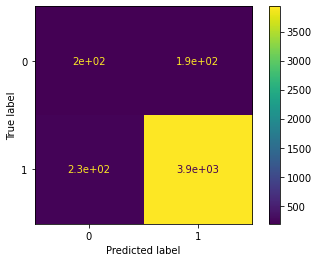

In [ ]:
disp.plot()

#Testing on other datasets -Domain Transfer/Transfer learning/Generalisation

#Covid dataset


In [ ]:
#import pandas as pd
# Load dataset
# Upload the train file from your local drive
#from google.colab import files
#Upload = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/covid dataset.csv",encoding='latin1')
df2.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16/03/2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16/03/2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16/03/2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16/03/2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16/03/2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df2['Sentiment'] = df2['Sentiment'].map({'Positive':int(1), 'Extremely Positive':int(0),'Negative':int(1),'Extremely Negative':int(1),'Neutral':int(1)})
df2['Sentiment'] = df2['Sentiment'].astype('category')

df2.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16/03/2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1.0
1,3800,48752,UK,16/03/2020,advice Talk to your neighbours family to excha...,1.0
2,3801,48753,Vagabonds,16/03/2020,Coronavirus Australia: Woolworths to give elde...,1.0
3,3802,48754,NaN,16/03/2020,My food stock is not the only one which is emp...,1.0
4,3803,48755,NaN,16/03/2020,"Me, ready to go at supermarket during the #COV...",1.0


In [ ]:
df2.dropna(subset = ["Sentiment"], inplace=True)

In [ ]:
df2.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16/03/2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1.0
1,3800,48752,UK,16/03/2020,advice Talk to your neighbours family to excha...,1.0
2,3801,48753,Vagabonds,16/03/2020,Coronavirus Australia: Woolworths to give elde...,1.0
3,3802,48754,NaN,16/03/2020,My food stock is not the only one which is emp...,1.0
4,3803,48755,NaN,16/03/2020,"Me, ready to go at supermarket during the #COV...",1.0


In [ ]:
df2['Sentiment'].value_counts()

1.0    6842
0.0    1212
Name: Sentiment, dtype: int64

In [ ]:
test_sents = list(df2['OriginalTweet'])

In [ ]:
predictions, raw_outputs = model.predict(test_sents)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/8054 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

In [ ]:
labels_dic_test = dict(enumerate(df2['Sentiment'].cat.categories))

In [ ]:
predictions = [labels_dic_test[i] for i in predictions]

In [ ]:
df2['label_pred'] = predictions

In [ ]:
df2['label_pred'].value_counts()

1.0    7954
0.0     100
Name: label_pred, dtype: int64

In [ ]:
df2.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,label_pred
0,3799,48751,London,16/03/2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1.0,1.0
1,3800,48752,UK,16/03/2020,advice Talk to your neighbours family to excha...,1.0,1.0
2,3801,48753,Vagabonds,16/03/2020,Coronavirus Australia: Woolworths to give elde...,1.0,1.0
3,3802,48754,NaN,16/03/2020,My food stock is not the only one which is emp...,1.0,1.0
4,3803,48755,NaN,16/03/2020,"Me, ready to go at supermarket during the #COV...",1.0,1.0


In [ ]:
print(sklearn.metrics.classification_report(df2['Sentiment'].to_numpy(),predictions))

              precision    recall  f1-score   support

         0.0       0.51      0.04      0.08      1212
         1.0       0.85      0.99      0.92      6842

    accuracy                           0.85      8054
   macro avg       0.68      0.52      0.50      8054
weighted avg       0.80      0.85      0.79      8054



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Airline tweets

In [ ]:
#from google.colab import files
#Upload = files.upload()

In [ ]:
#Upload

In [ ]:
#import io
#df3 = pd.read_csv(io.BytesIO(Upload['Tweets.csv']),encoding='latin1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/Tweets.csv",encoding='latin1')
df3.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df3['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
df3['airline_sentiment'] = df3['airline_sentiment'].map({'positive':int(0),'negative':int(1),'neutral':int(1)})
df3['airline_sentiment'] = df3['airline_sentiment'].astype('category')

df3.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,0,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df3.dropna(subset = ["airline_sentiment"], inplace=True)

In [ ]:
df3.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,0,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df3['airline_sentiment'].value_counts()

1    12277
0     2363
Name: airline_sentiment, dtype: int64

In [ ]:
test_sents = list(df3['text'])

In [ ]:
predictions, raw_outputs = model.predict(test_sents)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/14640 [00:00<?, ?it/s]

  0%|          | 0/1830 [00:00<?, ?it/s]

In [ ]:
labels_dic_test = dict(enumerate(df3['airline_sentiment'].cat.categories))

In [ ]:
predictions = [labels_dic_test[i] for i in predictions]

In [ ]:
df3['label_pred'] = predictions

In [ ]:
df3['label_pred'].value_counts()

1    14577
0       63
Name: label_pred, dtype: int64

In [ ]:
df3.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,label_pred
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,0,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),1
4,570300817074462722,1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),1


In [ ]:
print(sklearn.metrics.classification_report(df3['airline_sentiment'].to_numpy(),predictions))

              precision    recall  f1-score   support

           0       0.68      0.02      0.04      2363
           1       0.84      1.00      0.91     12277

    accuracy                           0.84     14640
   macro avg       0.76      0.51      0.47     14640
weighted avg       0.82      0.84      0.77     14640

